In [1]:
from diffusers import DiffusionPipeline
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline = DiffusionPipeline.from_pretrained(
    'joeySadventure/sd_raw_pretrained.params', safety_checker=None)

scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer

del pipeline

device, scheduler, tokenizer

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/liyuanhang/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


('cuda',
 PNDMScheduler {
   "_class_name": "PNDMScheduler",
   "_diffusers_version": "0.14.0",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "set_alpha_to_one": false,
   "skip_prk_steps": true,
   "steps_offset": 1,
   "trained_betas": null
 },
 CLIPTokenizer(name_or_path='/home/liyuanhang/.cache/huggingface/hub/models--joeySadventure--sd_raw_pretrained.params/snapshots/3e8255dfdd3b0de298d7995fbee8069498d16c1d/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pa

In [2]:
%run 1.encoder.ipynb
%run 2.vae.ipynb
%run 3.unet.ipynb

encoder.to(device)
vae.to(device)
unet.to(device)

encoder.eval()
vae.eval()
unet.eval()

UNet(
  (in_vae): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_time): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_block0): DownBlock(
    (tf0): Transformer(
      (norm_in): GroupNorm(32, 320, eps=1e-06, affine=True)
      (cnn_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
      (norm_atten0): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (atten1): CrossAttention(
        (q): Linear(in_features=320, out_features=320, bias=False)
        (k): Linear(in_features=320, out_features=320, bias=False)
        (v): Linear(in_features=320, out_features=320, bias=False)
        (out): Linear(in_features=320, out_features=320, bias=True)
      )
      (norm_atten1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (atten2): CrossAttention(
        (q): Linear(in_features=320, out_features=320, bias=False)
      

In [3]:
@torch.no_grad()
def generate(text):
    #词编码
    #[1, 77]
    pos = tokenizer(text,
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)
    neg = tokenizer('',
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)

    #[1, 77, 768]
    pos = encoder(pos)
    neg = encoder(neg)

    #[1+1, 77, 768] -> [2, 77, 768]
    out_encoder = torch.cat((neg, pos), dim=0)

    #vae的压缩图,从随机噪声开始
    out_vae = torch.randn(1, 4, 64, 64, device=device)

    #生成50个时间步,一般是从980-0
    scheduler.set_timesteps(50, device=device)
    for time in scheduler.timesteps:

        #往图中加噪音
        #[1+1, 4, 64, 64] -> [2, 4, 64, 64]
        noise = torch.cat((out_vae, out_vae), dim=0)
        noise = scheduler.scale_model_input(noise, time)

        #计算噪音
        #[2, 4, 64, 64],[2, 77, 768],scala -> [2, 4, 64, 64]
        pred_noise = unet(out_vae=noise, out_encoder=out_encoder, time=time)

        #从正例图中减去反例图
        #[2, 4, 64, 64] -> [1, 4, 64, 64]
        pred_noise = pred_noise[0] + 7.5 * (pred_noise[1] - pred_noise[0])

        #重新添加噪音,以进行下一步计算
        #[1, 4, 64, 64]
        out_vae = scheduler.step(pred_noise, time, out_vae).prev_sample

    #从压缩图恢复成图片
    out_vae = 1 / 0.18215 * out_vae
    #[1, 4, 64, 64] -> [1, 3, 512, 512]
    image = vae.decoder(out_vae)

    #转换成图片数据
    image = image.cpu()
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    image = image.permute(0, 2, 3, 1)
    return image.numpy()[0]


generate('a drawing of a star with a jewel in the center').shape

(512, 512, 3)

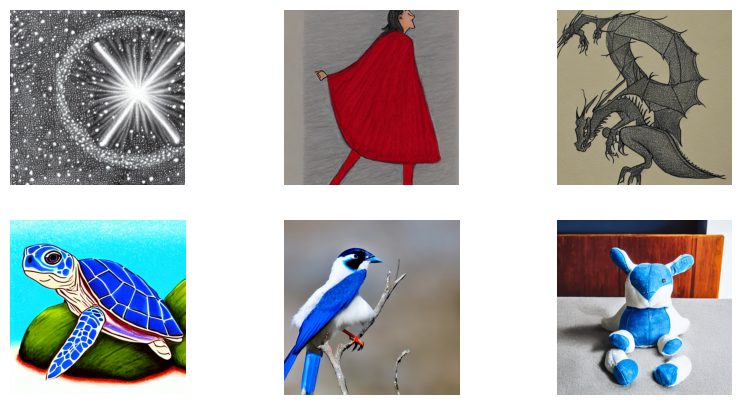

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show():
    texts = [
        'a drawing of a star with a jewel in the center',  #宝石海星
        'a drawing of a woman in a red cape',  #迷唇姐
        'a drawing of a dragon sitting on its hind legs',  #肥大
        'a drawing of a blue sea turtle holding a rock',  #拉普拉斯
        'a blue and white bird with its wings spread',  #急冻鸟
        'a blue and white stuffed animal sitting on top of a white surface',  #卡比兽
        #"a green and yellow toy with a red nose"
        #'a yellow mouse'
    ]

    images = [generate(i) for i in texts]

    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()


show()

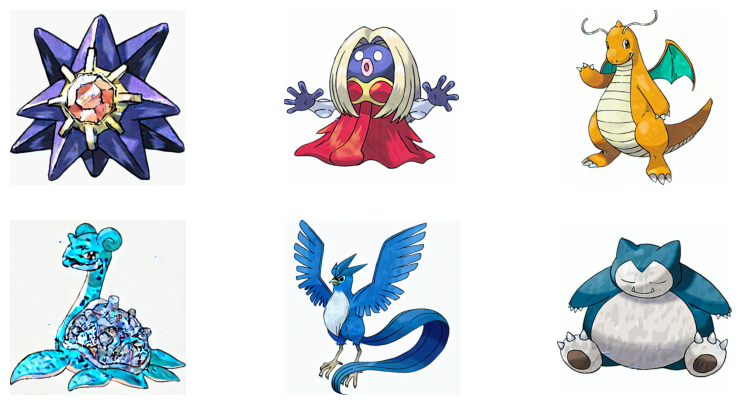

In [5]:
from transformers import PreTrainedModel, PretrainedConfig


#包装类
class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.unet = unet.to('cpu')


#加载训练好的模型
unet = Model.from_pretrained('joeySadventure/sd_finetune_pokeman.unet').unet
unet.eval().to(device)

show()